In [46]:
import bootcamp_utils
import numpy as np
import glob
import pandas as pd

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

//anaconda/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


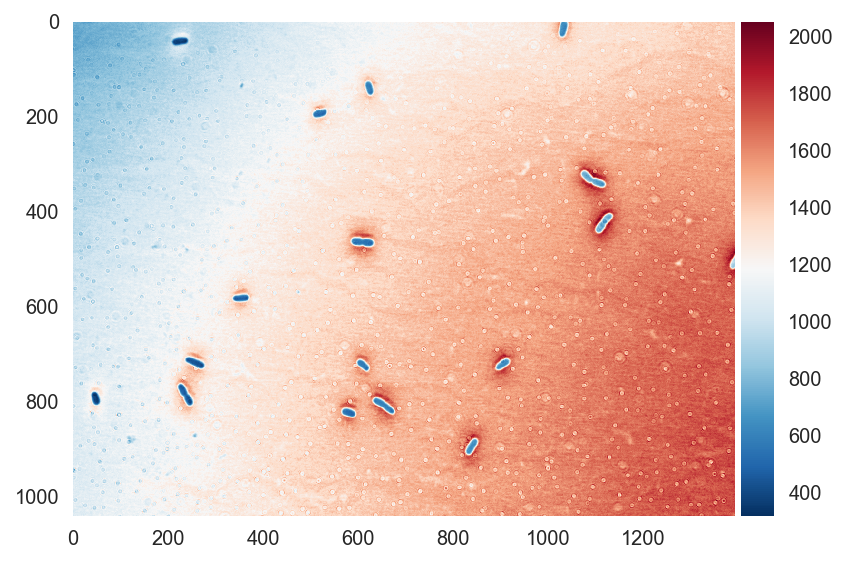

In [3]:
# load data from 'data/HG105_images into a list

FITC_list = glob.glob('data/HG105_images/*FITC*.tif')
phase_list = glob.glob('data/HG105_images/*phase*.tif')
im_FITC_list = [skimage.io.imread(file) for file in FITC_list]
im_phase_list = [skimage.io.imread(file) for file in phase_list]
with sns.axes_style('dark'):
    _ = skimage.io.imshow(im_phase_list[0], cmap = plt.cm.RdBu_r)


//anaconda/envs/py36/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
//anaconda/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


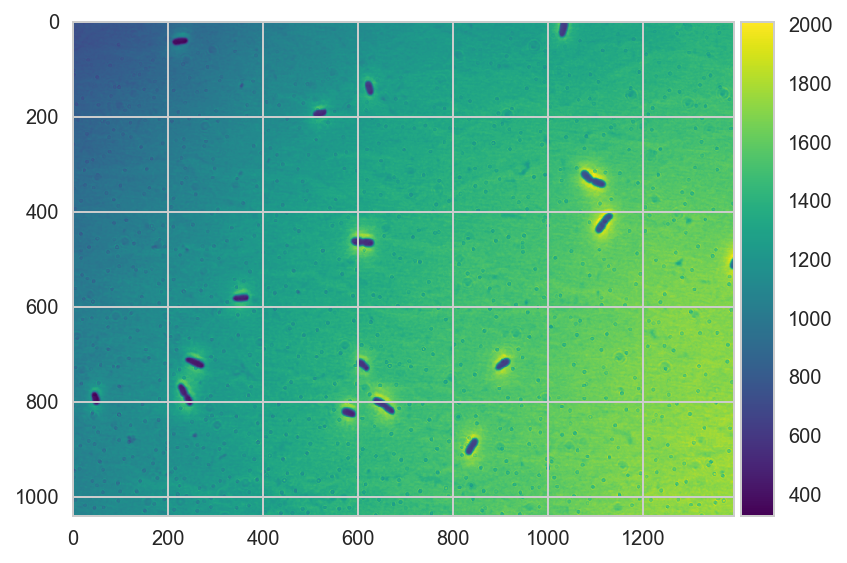

In [4]:
# segmentation on phase
selem = skimage.morphology.square(3)
phase_filt = []
FITC_filt = []

phase_filt = [skimage.filters.median(image, selem) for image in im_phase_list]
FITC_filt = [skimage.filters.median(image, selem) for image in im_phase_list]
skimage.io.imshow(phase_filt[0])


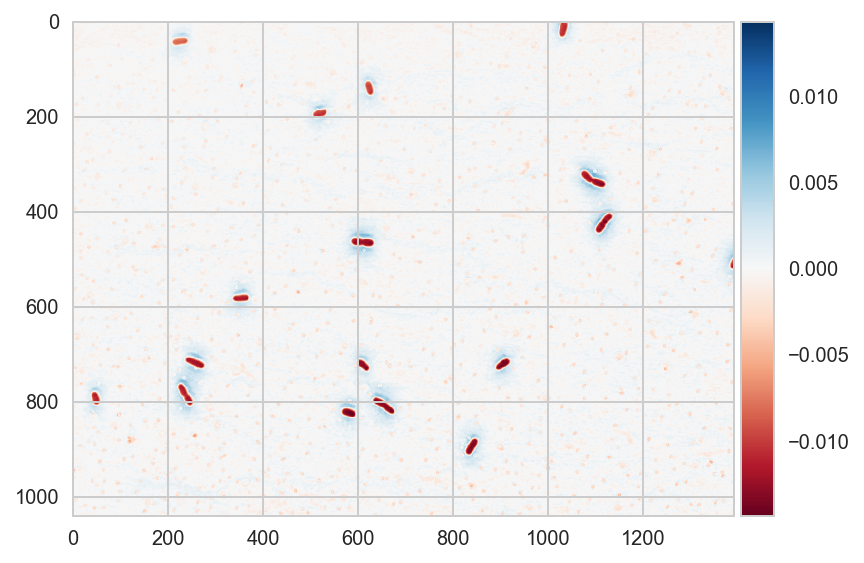

In [5]:
# background substraction using a gaussian blur
phase_bg = []
phase_bg = [skimage.filters.gaussian(image, 50.0) for image in phase_filt]
#skimage.io.imshow(phase_bg[0])
phase_sub = []

for i, image in enumerate(phase_filt):
    phase_sub += [skimage.img_as_float(image) - phase_bg[i]]
skimage.io.imshow(phase_sub[0])

//anaconda/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


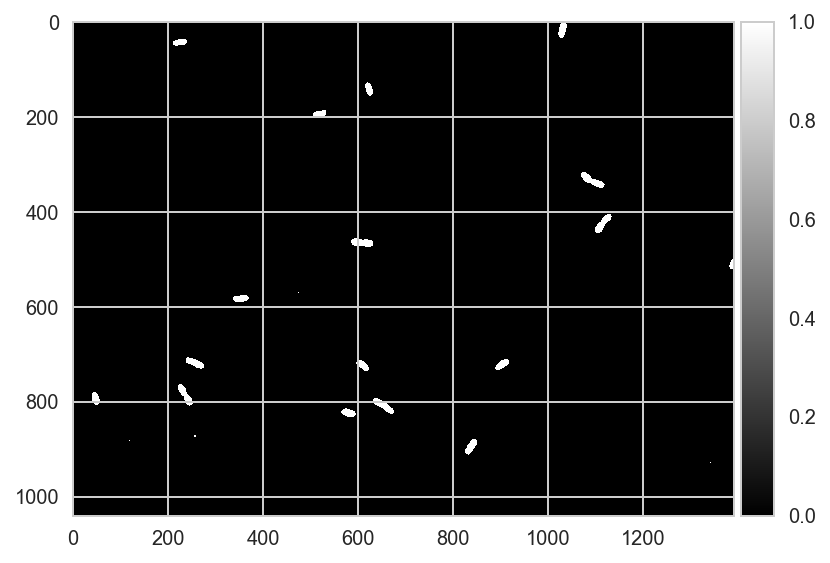

In [6]:
# Thresholding
thresh_otsu = []
phase_bw = []
thresh_otsu = [skimage.filters.threshold_otsu(image) for image in phase_sub]
for i, image in enumerate(phase_sub):
    phase_bw += [image < thresh_otsu[i]]

skimage.io.imshow(phase_bw[0], cmap=plt.cm.gray)


//anaconda/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


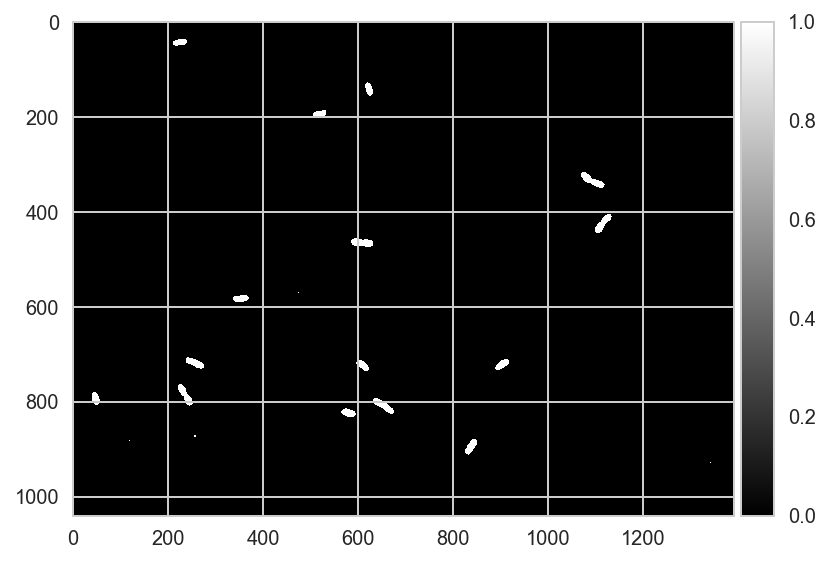

In [7]:
# border clearing (only works on black and white images!)
phase_bw = [skimage.segmentation.clear_border(image) for image in phase_bw]
skimage.io.imshow(phase_bw[0], cmap=plt.cm.gray)

//anaconda/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


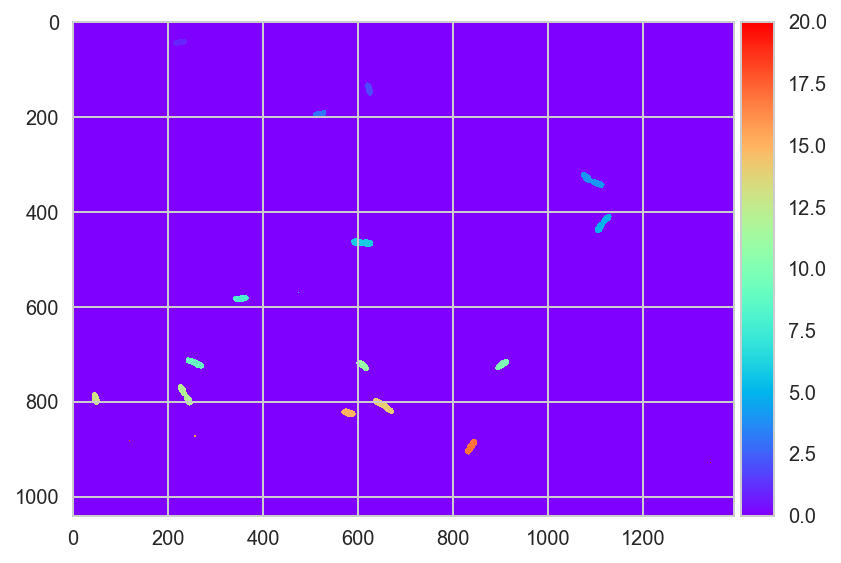

In [8]:
# labeling cells/regions for subsequent analysis. corresponding cells in the array have the specific number of the label
phase_labeled = []
phase_labeled = [skimage.measure.label(image, background=0) for image in phase_bw]
skimage.io.imshow(phase_labeled[0], cmap=plt.cm.rainbow)

In [9]:
# get attributes

props = []
props = [skimage.measure.regionprops(phase_labeled[i], intensity_image=FITC_filt[i]) 
                     for i in range(len(phase_labeled))]


In [10]:
#filter by size. 
phase_bw_filt = []
phase_bw_filt = [image > 0 for image in phase_labeled]
cutoff = 200
for i, image in enumerate(props):
    for prop in image:
        if prop.area < cutoff:
            phase_bw_filt[i][phase_labeled[i]==prop.label] = 0

In [11]:
#get FL intensities
index = []
inten = []
for i, image in enumerate(props):
    for prop in image:
        index += [i]
        inten += [prop.area * prop.mean_intensity]
FL_df = pd.DataFrame({'image':index,
                      'FL Intensity':inten})
        

In [12]:
FL_df

,FL Intensity,image
0,145768.0,0
1,216702.0,0
2,214157.0,0
3,613757.0,0
4,558483.0,0
5,438458.0,0
6,3789.0,0
7,237839.0,0
8,288176.0,0
9,335345.0,0


In [14]:
# plot all data 
FL_stats = FL_df.describe()

In [17]:
FL_stats

,FL Intensity,image
count,142.000000,142.000000
mean,198005.492958,3.880282
std,150599.785786,2.653734
min,858.000000,0.000000
25%,41965.250000,1.000000
50%,214099.500000,4.000000
75%,288929.750000,6.000000
max,700918.000000,8.000000


A total of 142.0 cells were counted in 9 images.
The mean fluorescence measured was 198005.49 ± 150599.79


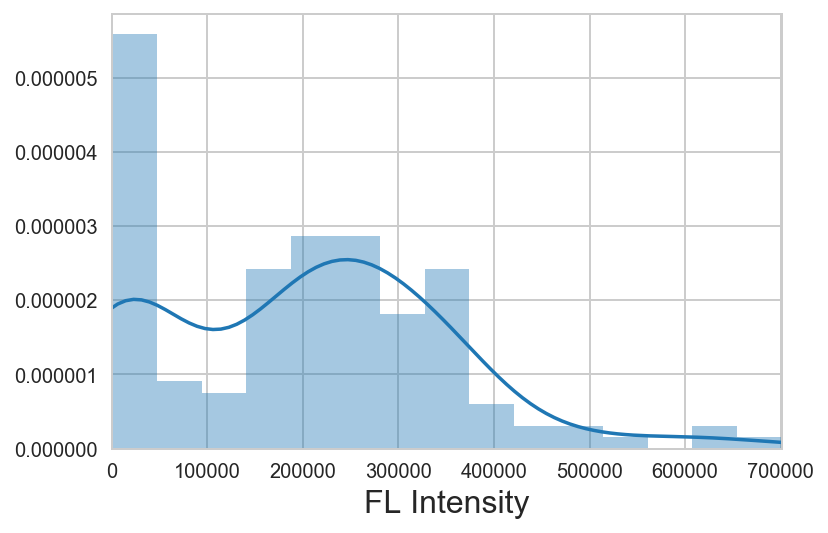

In [45]:
print("A total of {} cells were counted in 9 images.".format(FL_stats.loc['count','FL Intensity']))
print("The mean fluorescence measured was {:.2f} ± {:.2f}".format(FL_stats.loc['mean','FL Intensity'],FL_stats.loc['std','FL Intensity']))

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,701000])
_ = sns.distplot(FL_df['FL Intensity'], bins = 15)
#ax.hist(FL_df['FL Intensity'])

In [51]:
# bootstrap for mean and std
FL_bs_mean = bootcamp_utils.draw_bs_reps(FL_df['FL Intensity'], np.mean)
FL_bs_std = bootcamp_utils.draw_bs_reps(FL_df['FL Intensity'], np.std)
print(np.percentile(FL_bs_mean, [2.5, 97.5]))
print(np.percentile(FL_bs_std, [2.5, 97.5]))

[ 173760.87042254  221970.2221831 ]
[ 132022.82408237  167492.45813408]
